<a href="https://colab.research.google.com/github/orannahum/Image-Segmentation/blob/main/better_version_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial No. 3

## 1. Import Packages

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import itertools


## 2. Load Data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePZ64SN/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePZ64SN/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
Train dataset size: 2576
Validation dataset size: 1104
Test dataset size: 3669
['file_name', 'image', 'label', 'segmentation_mask', 'species']
Label: 6
Species: 0
Image shape: (333, 500, 3)
Image values: 0-255
Segmentation mask shape: (333, 500, 1)
Segmentation mask values: {1, 2, 3}


file_name  ... species
0                     b'Birman_140.jpg'  ...       0
1               b'Russian_Blue_169.jpg'  ...       0
2  b'american_pit_bull_terrier_102.jpg'  ...       1
3            b'wheaten_terrier_172.jpg'  ...       1
4          b'British_Shorthair_155.jpg'  ...       0
5                      b'boxer_158.jpg'  ...       1
6  b'american_pit_bull_terrier_109.jpg'  ...       1
7     b'english_cocker_spaniel_172.jpg'  ...       1
8                 b'leonberger_161.jpg'  ...       1
9               b'basset_hound_158.jpg'  ...       1

[10 rows x 5 columns]
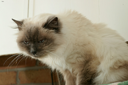
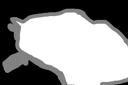
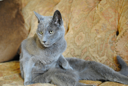
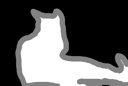
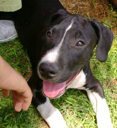
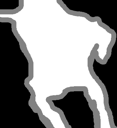
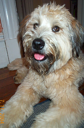
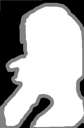
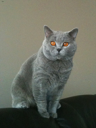
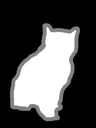
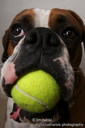
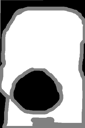
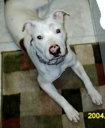
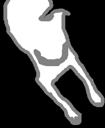
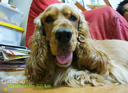
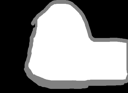
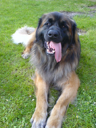
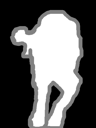
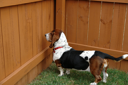
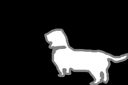

In [2]:
(raw_train_dataset, raw_test_dataset), dataset_info = (
    tfds.load('oxford_iiit_pet', split=('train', 'test'), with_info=True))

# Since there's no validation/training split, we'll take 30%
validation_count = int(0.3 * len(raw_train_dataset))
raw_validation_dataset = raw_train_dataset.take(validation_count)
raw_train_dataset = raw_train_dataset.skip(validation_count)

# Check size of dataset
print(f'Train dataset size: {len(raw_train_dataset)}')
print(f'Validation dataset size: {len(raw_validation_dataset)}')
print(f'Test dataset size: {len(raw_test_dataset)}')

# Visualize the structure of the data
for example in raw_train_dataset.take(1):
  print(list(example.keys()))
  image = example["image"]
  seg_mask = example["segmentation_mask"]
  all_values = set(seg_mask.numpy().flatten())
  image_values = set(image.numpy().flatten())

  print(f'Label: {example["label"]}')
  print(f'Species: {example["species"]}')
  print(f'Image shape: {image.shape}')
  print(f'Image values: {min(image_values)}-{max(image_values)}')
  print(f'Segmentation mask shape: {seg_mask.shape}')
  print(f'Segmentation mask values: {all_values}')

# Visualize a few samples from the dataset

# Segmentation values are 1 (Inside), 2 (Outside) and 3 (Edge)
# To visualize, we transform these to white, black and gray (respectively)
def to_visible_segmentation_mask(image_tensor):
    shifted = (image_tensor-1)
    return 64 * shifted * shifted - 319 * shifted + 255

def update_segmentation_mask(data_point):
  data_point['segmentation_mask'] = to_visible_segmentation_mask(data_point['segmentation_mask'])
  return data_point

tfds.as_dataframe(raw_train_dataset.take(10).map(update_segmentation_mask), dataset_info)

In [3]:
# Before we start, we'll transform the dataset to x, y pairs in an easier
# format to use
@tf.function
def normalize_datapoint(datapoint):
  input_image = datapoint['image']
  # Reduce one so the classes are [0, 1, 2] instead of [1, 2, 3]
  input_mask = datapoint['segmentation_mask'] - 1

  # Here we can do any preprocessing on the data
  input_image = tf.image.resize(input_image, (128, 128))
  input_mask = tf.image.resize(input_mask, (128, 128))

  return input_image, input_mask

train_dataset = raw_train_dataset.map(normalize_datapoint)
validation_dataset = raw_validation_dataset.map(normalize_datapoint)
test_dataset = raw_test_dataset.map(normalize_datapoint)

## 3. Define Parameters 

In [4]:
num_classes = 3         # number of classes
lr = 5e-4               # learning rate
epochs = 20             # number of epochs
batch_size = 16         # batch size
dropout = 0.5           # Dropout percentage to use
kernel_sizes = 4
strides = 2



## 4. Build Model using Sequential

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3), name='image'),
    tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255.),

    tf.keras.layers.Conv2D(128, kernel_sizes, strides=strides, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(256, kernel_sizes, strides=strides, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(512, kernel_sizes, strides=strides, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(1024, kernel_sizes, strides=strides, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2DTranspose(1024, kernel_sizes, strides=strides, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2DTranspose(512, kernel_sizes, strides=strides, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2DTranspose(256, kernel_sizes, strides=strides, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2DTranspose(num_classes, kernel_sizes, strides=strides, padding='same'),
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       6272      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       524544    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                        

##  5. Train the Model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
  6/161 [>.............................] - ETA: 1:29 - loss: 1.0416 - accuracy: 0.5034WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2049s vs `on_train_batch_end` time: 0.3072s). Check your callbacks.


161/161 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.6828

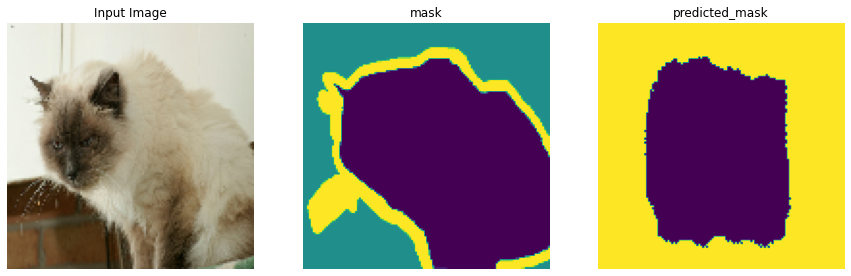

161/161 [==============================] - 144s 666ms/step - loss: 0.7473 - accuracy: 0.6828 - val_loss: 0.7391 - val_accuracy: 0.6968
Epoch 2/20
161/161 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.7389

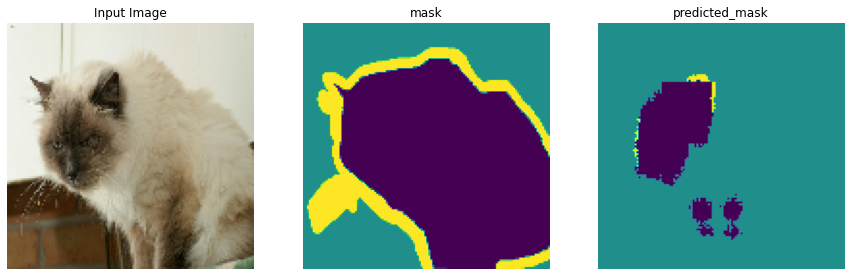

161/161 [==============================] - 109s 663ms/step - loss: 0.6301 - accuracy: 0.7389 - val_loss: 0.7328 - val_accuracy: 0.6740
Epoch 3/20
161/161 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.7640

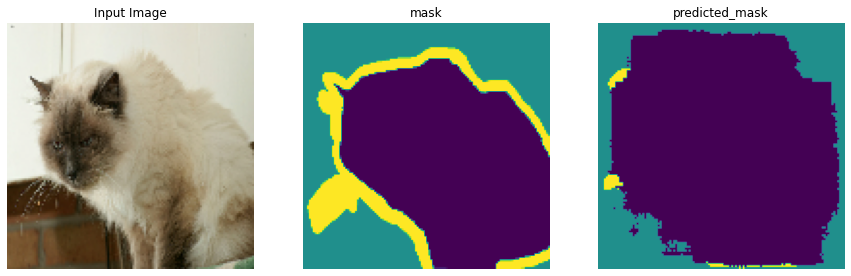

161/161 [==============================] - 112s 677ms/step - loss: 0.5646 - accuracy: 0.7640 - val_loss: 0.8848 - val_accuracy: 0.6649
Epoch 4/20
161/161 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.7811

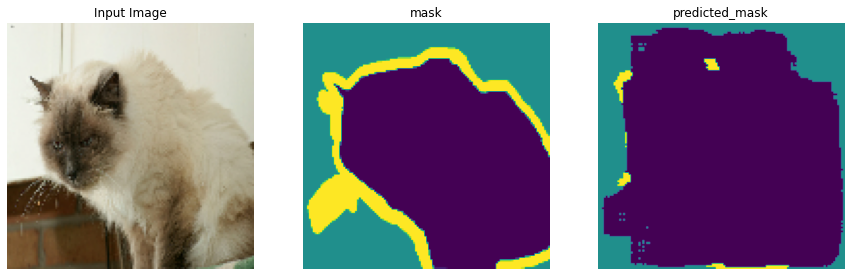

161/161 [==============================] - 109s 663ms/step - loss: 0.5245 - accuracy: 0.7811 - val_loss: 0.7645 - val_accuracy: 0.6999
Epoch 5/20
161/161 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.7936

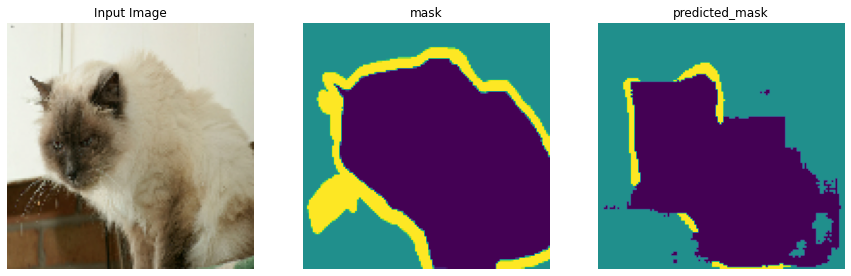

161/161 [==============================] - 111s 676ms/step - loss: 0.4953 - accuracy: 0.7936 - val_loss: 0.5002 - val_accuracy: 0.7931
Epoch 6/20
161/161 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.8033

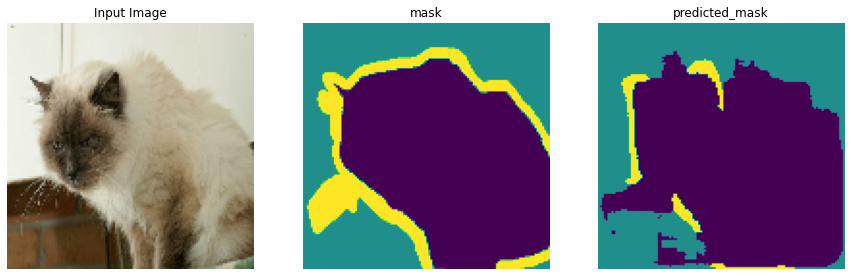

161/161 [==============================] - 109s 663ms/step - loss: 0.4732 - accuracy: 0.8033 - val_loss: 0.5722 - val_accuracy: 0.7719
Epoch 7/20
161/161 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.8112

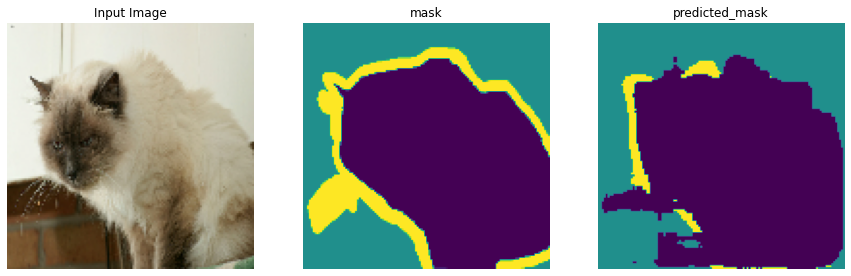

161/161 [==============================] - 112s 678ms/step - loss: 0.4544 - accuracy: 0.8112 - val_loss: 0.5344 - val_accuracy: 0.7822
Epoch 8/20
161/161 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.8179

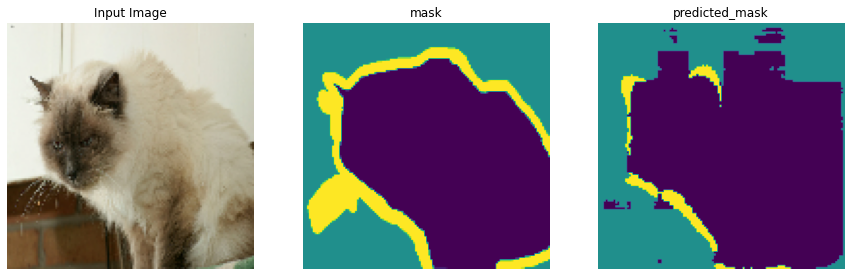

161/161 [==============================] - 110s 665ms/step - loss: 0.4399 - accuracy: 0.8179 - val_loss: 0.6168 - val_accuracy: 0.7509
Epoch 9/20
161/161 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8231

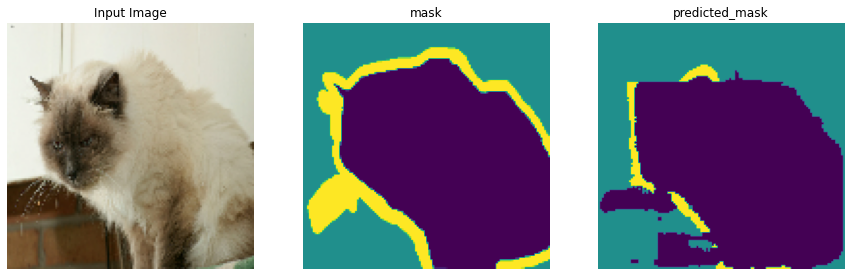

161/161 [==============================] - 110s 665ms/step - loss: 0.4244 - accuracy: 0.8231 - val_loss: 0.5264 - val_accuracy: 0.7857
Epoch 10/20
161/161 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.8292

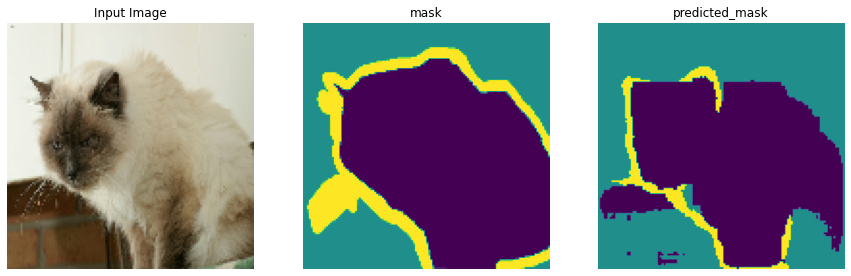

161/161 [==============================] - 112s 677ms/step - loss: 0.4101 - accuracy: 0.8292 - val_loss: 0.5036 - val_accuracy: 0.7935
Epoch 11/20
161/161 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.8347

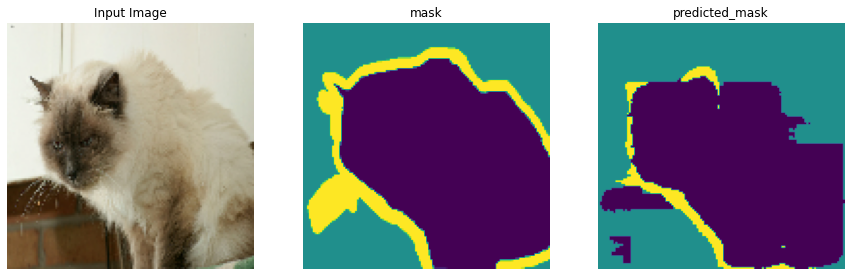

161/161 [==============================] - 109s 664ms/step - loss: 0.3970 - accuracy: 0.8347 - val_loss: 0.5028 - val_accuracy: 0.7959
Epoch 12/20
161/161 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8389

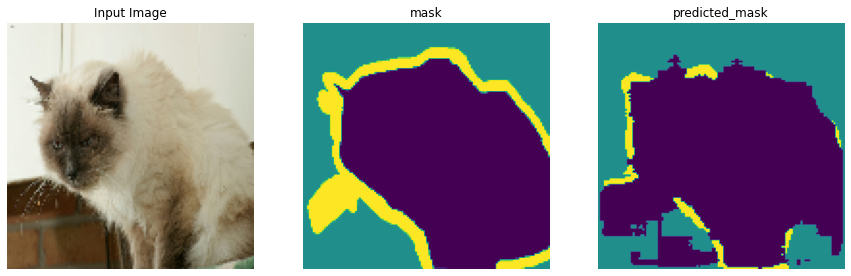

161/161 [==============================] - 109s 664ms/step - loss: 0.3860 - accuracy: 0.8389 - val_loss: 0.6068 - val_accuracy: 0.7657
Epoch 13/20
161/161 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.8412

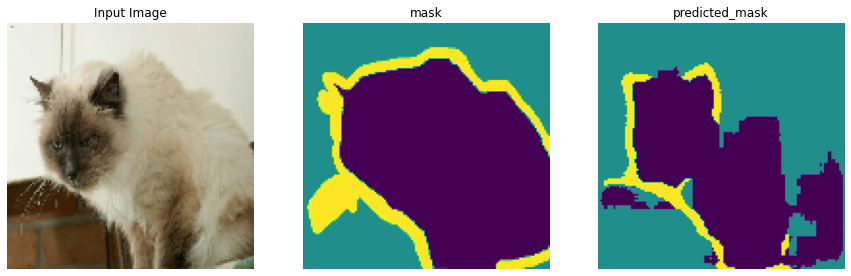

161/161 [==============================] - 112s 677ms/step - loss: 0.3800 - accuracy: 0.8412 - val_loss: 0.4813 - val_accuracy: 0.8021
Epoch 14/20
161/161 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8471

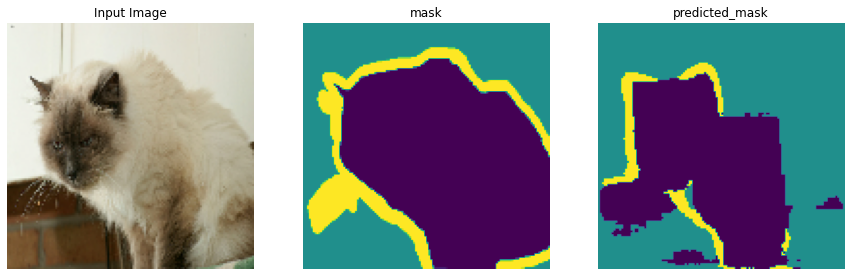

161/161 [==============================] - 112s 677ms/step - loss: 0.3662 - accuracy: 0.8471 - val_loss: 0.5173 - val_accuracy: 0.7985
Epoch 15/20
161/161 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.8504

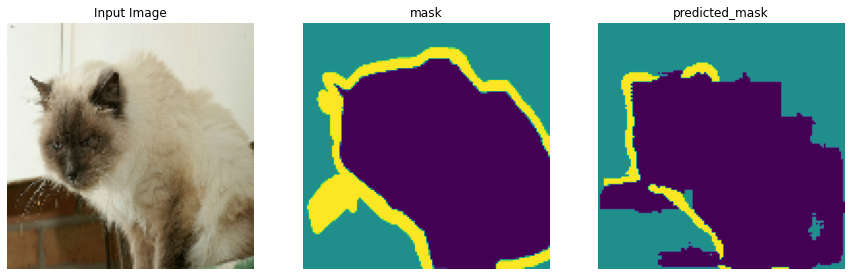

161/161 [==============================] - 111s 676ms/step - loss: 0.3579 - accuracy: 0.8504 - val_loss: 0.4948 - val_accuracy: 0.8041
Epoch 16/20
161/161 [==============================] - ETA: 0s - loss: 0.3436 - accuracy: 0.8554

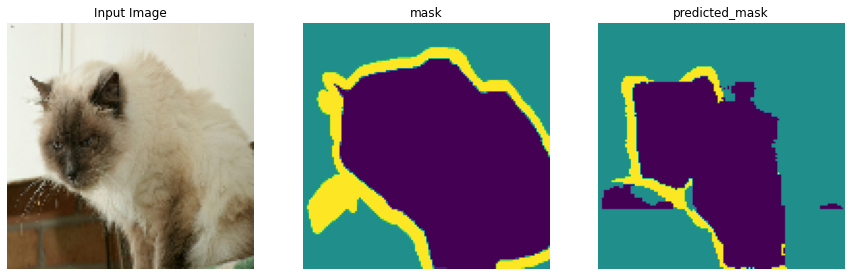

161/161 [==============================] - 112s 679ms/step - loss: 0.3436 - accuracy: 0.8554 - val_loss: 0.5246 - val_accuracy: 0.8024
Epoch 17/20
161/161 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8575

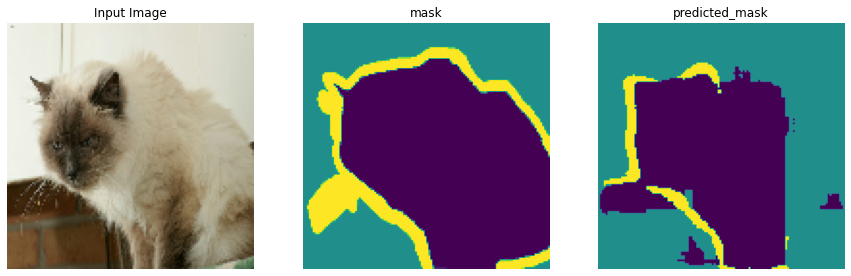

161/161 [==============================] - 112s 677ms/step - loss: 0.3386 - accuracy: 0.8575 - val_loss: 0.5233 - val_accuracy: 0.8099
Epoch 18/20
161/161 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8616

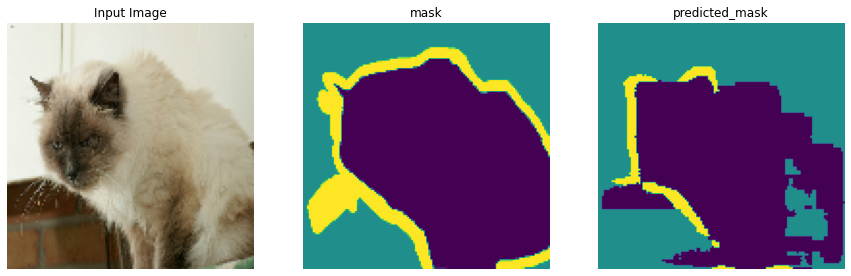

161/161 [==============================] - 109s 663ms/step - loss: 0.3287 - accuracy: 0.8616 - val_loss: 0.4944 - val_accuracy: 0.8162
Epoch 19/20
161/161 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.8644

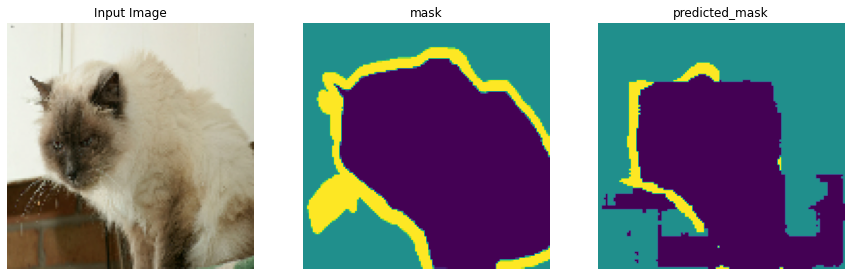

161/161 [==============================] - 111s 676ms/step - loss: 0.3219 - accuracy: 0.8644 - val_loss: 0.5681 - val_accuracy: 0.8048
Epoch 20/20
161/161 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8675

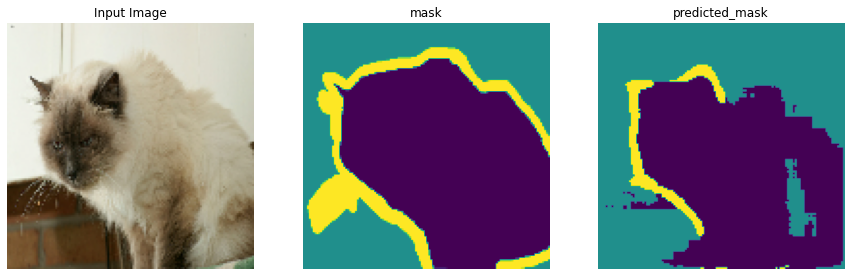

161/161 [==============================] - 112s 677ms/step - loss: 0.3138 - accuracy: 0.8675 - val_loss: 0.4840 - val_accuracy: 0.8232


In [6]:
import matplotlib.pyplot as plt

# A function to display images and masks
def display_image_mask(image, mask, predicted_mask):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.axis('off')

    # predicted_mask = tf.convert_to_tensor(predicted_mask)
    # The predicted mask currently gives probabilities; we take the argmax to get class values
    predicted_mask = tf.expand_dims(tf.argmax(predicted_mask, axis=-1), axis=-1)

    plt.subplot(1, 3, 3)
    plt.title('predicted_mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(predicted_mask))
    plt.axis('off')

    plt.show()

# A function to show visualize the prediction of the model on a number of images
# from the given dataset
def display_prediction(model, dataset, image_count):
  for image_batch, mask_batch in dataset.batch(image_count).take(1):
    predicted_mask_batch = model.predict(image_batch)
    for image, mask, predicted_mask in zip(image_batch, mask_batch, predicted_mask_batch):
      display_image_mask(image, mask, predicted_mask)


# A callback to visualize results during training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    display_prediction(model, train_dataset, 1)

# define the optimizer and compile the model
adam = optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset.batch(batch_size), 
                    validation_data=validation_dataset.batch(batch_size),
                    epochs=epochs,
                    callbacks=[DisplayCallback()])


## 6. Visualize

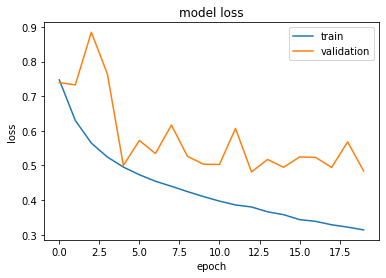

In [7]:
# plot train and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show(); plt.close()


Train samples


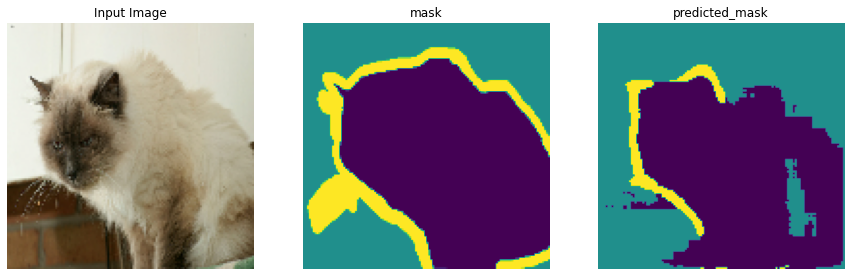

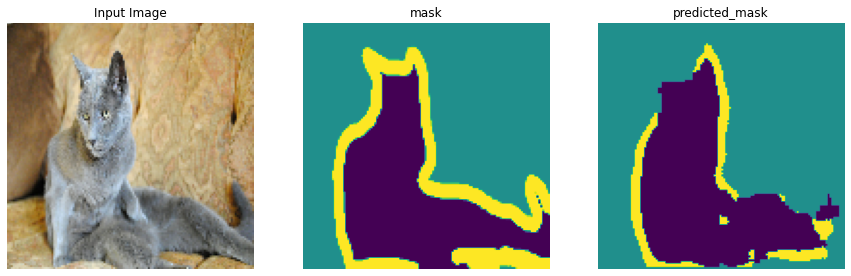

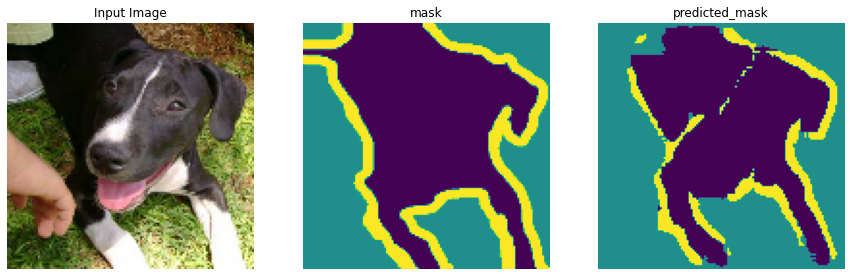

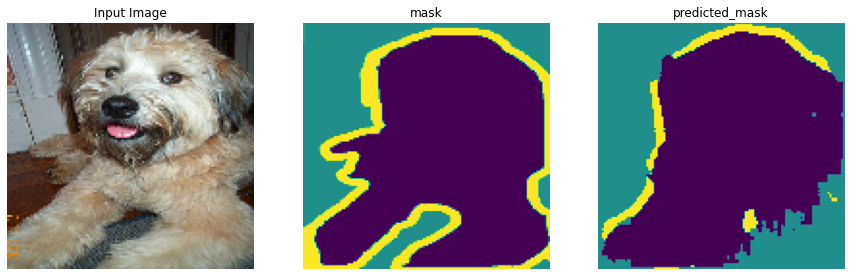

Validation samples


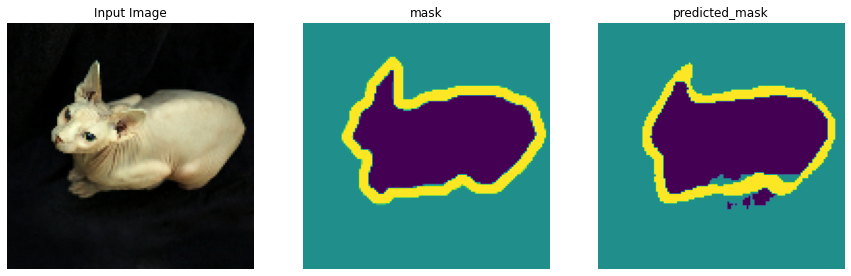

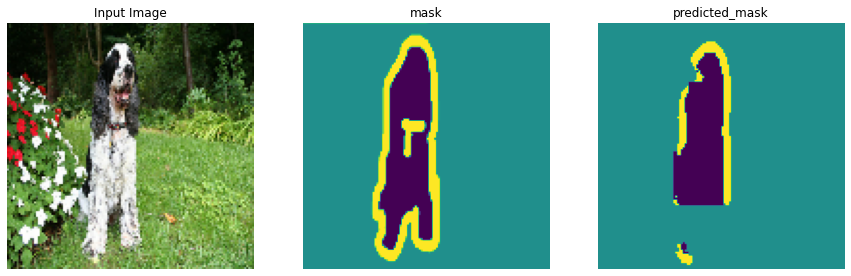

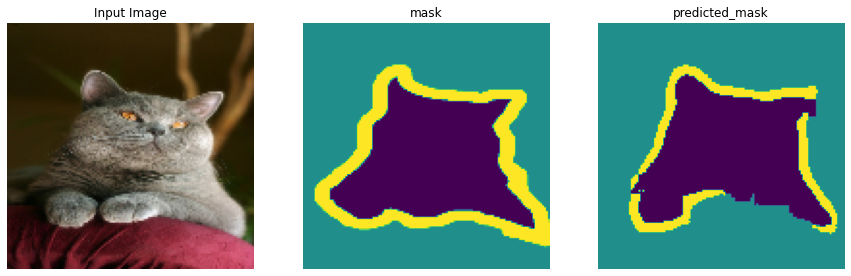

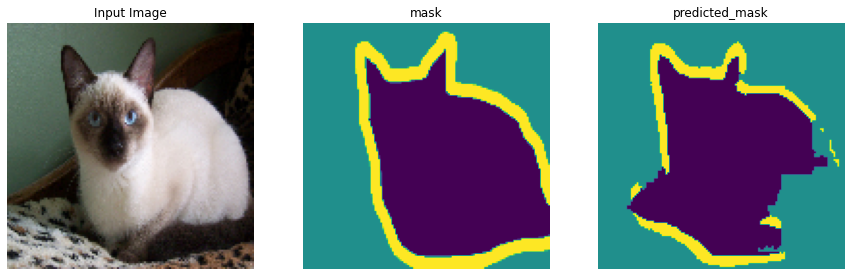

In [8]:
print('Train samples')
display_prediction(model, train_dataset, 4)

print('Validation samples')
display_prediction(model, validation_dataset, 4)


## 7. Model Evaluation

In [9]:
test_loss, test_acc = model.evaluate(test_dataset.batch(batch_size))

# Print results
print('test loss:', test_loss)
print('test accuracy:', test_acc)

230/230 [==============================] - 43s 187ms/step - loss: 0.4782 - accuracy: 0.8251
test loss: 0.478224515914917
test accuracy: 0.8250867128372192


Test samples


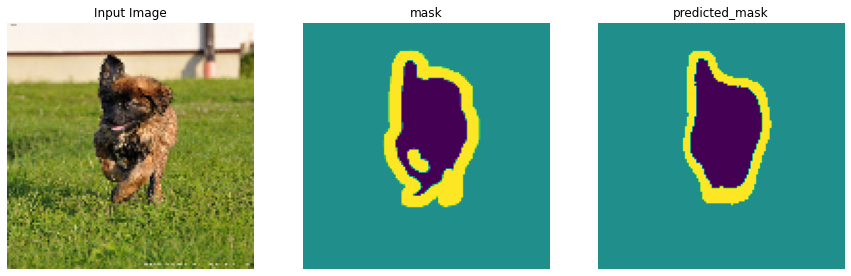

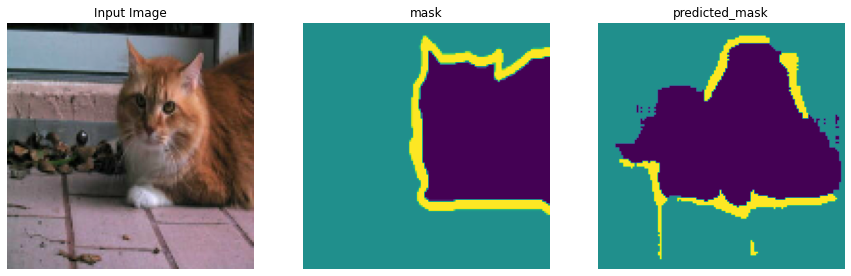

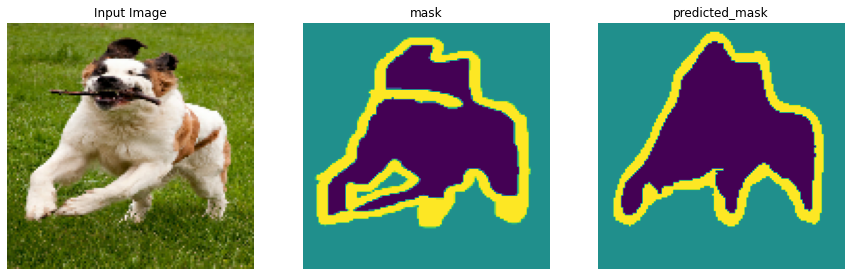

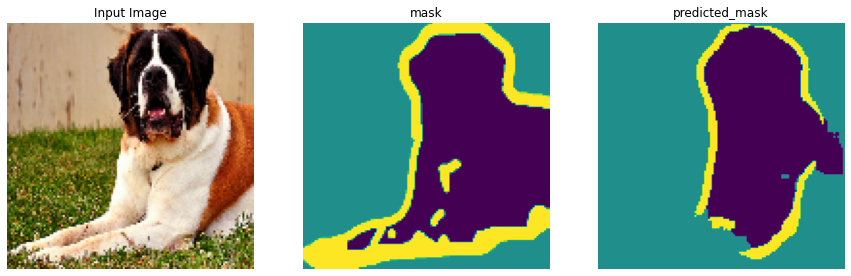

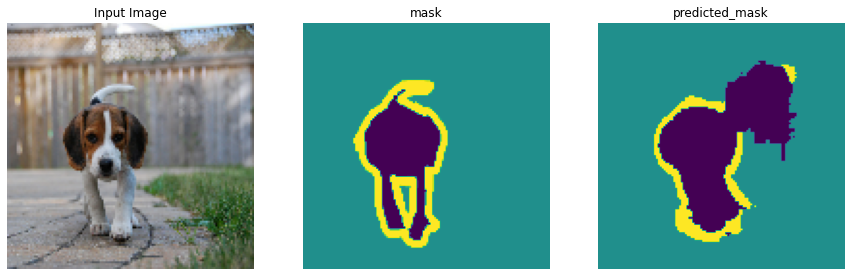

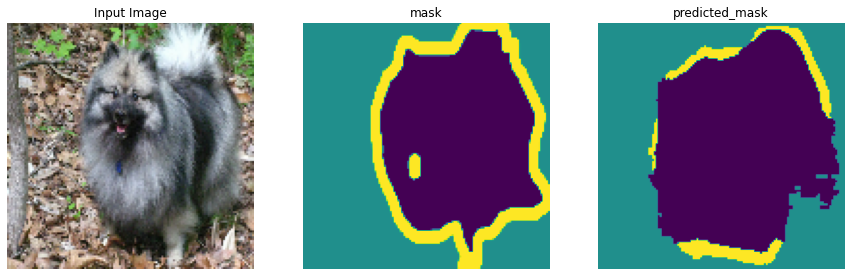

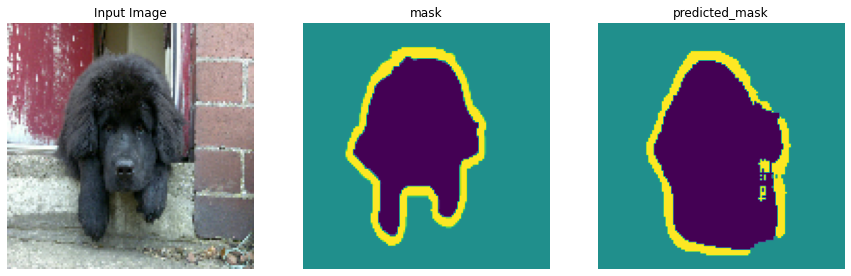

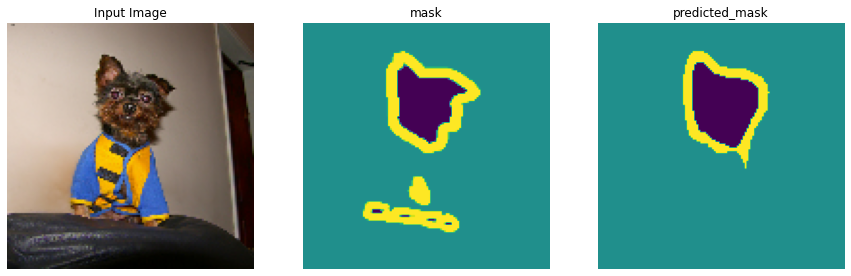

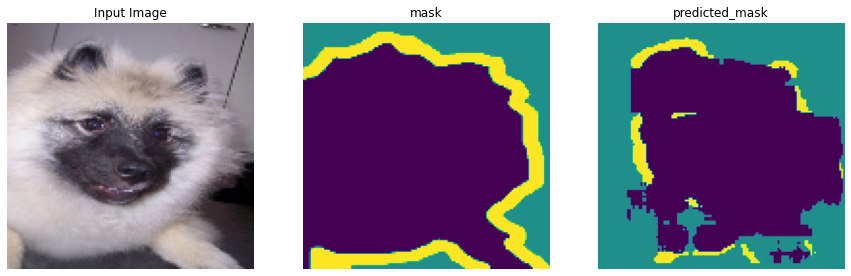

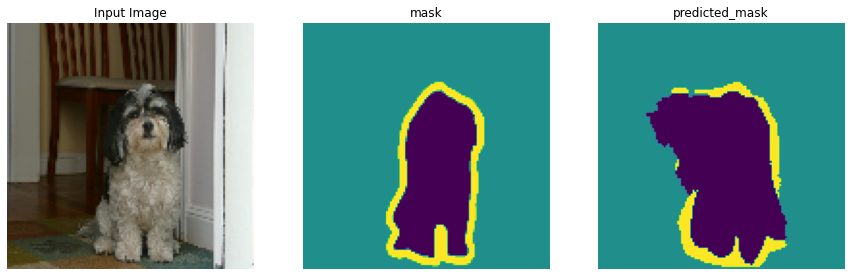

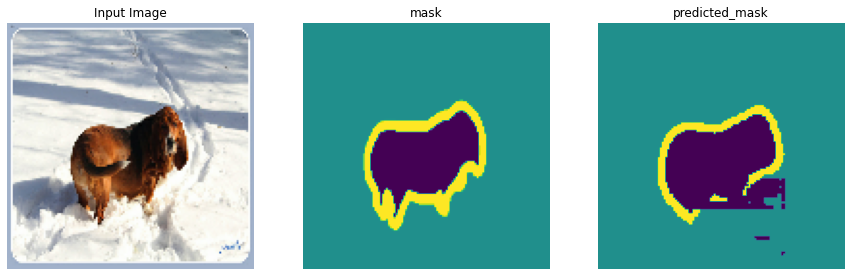

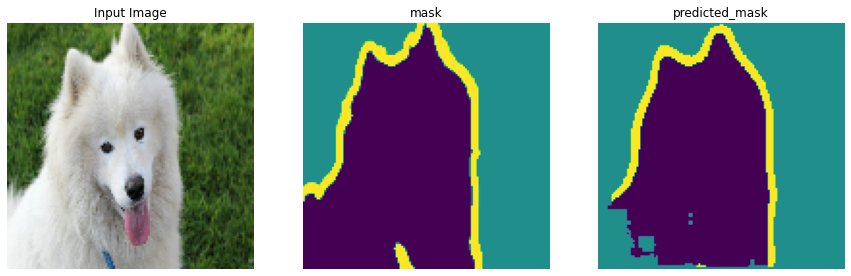

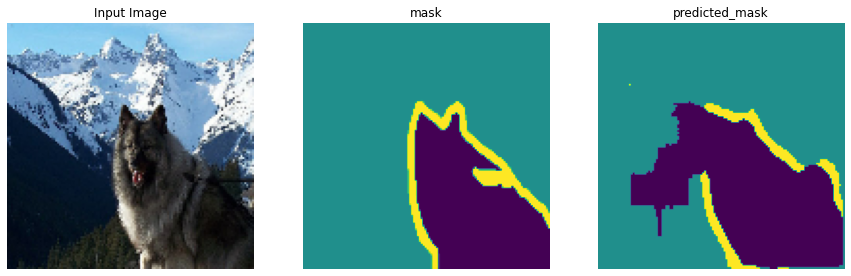

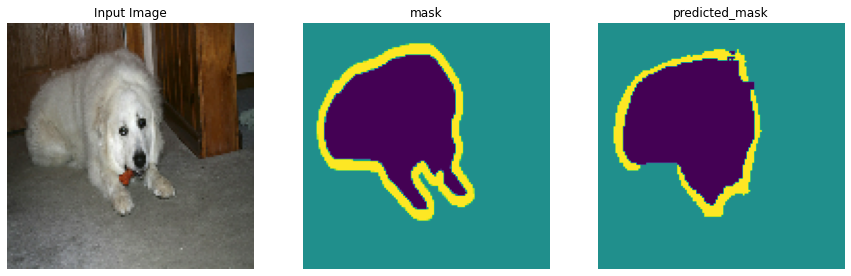

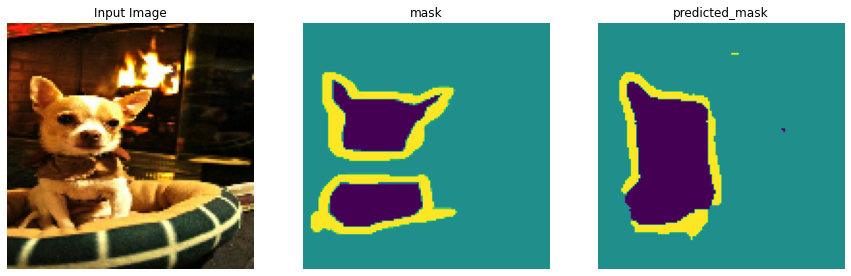

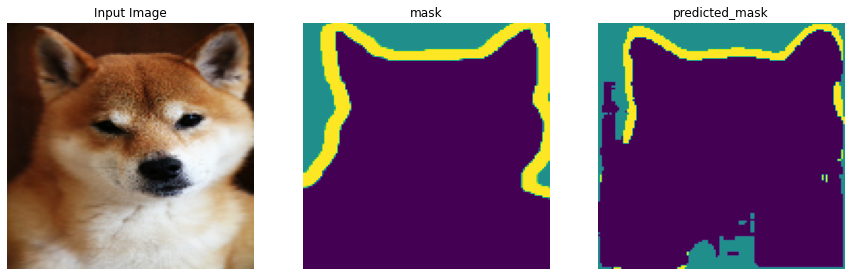

In [10]:
print('Test samples')
display_prediction(model, test_dataset, 16)


In [11]:
# Show the image mask of an image loaded from a local file
def get_image_mask(image_path):
  # Load the image into PIL format
  image = tf.keras.preprocessing.image.load_img(image_path)
  # Turn from PIL format to a tensor of values
  image_arr = tf.keras.preprocessing.image.img_to_array(image)
  # Resize to what the model expected
  image_arr = tf.image.resize(image_arr, (128, 128))
  # Turn into a batch of 1 image, since the model expects batches
  image_batch = tf.expand_dims(image_arr, axis=0)
  # Do the actual prediction
  prediction_mask_batch = model.predict(image_batch, batch_size=1)[0]
  # Take the first prediction in the batch
  prediction_mask = prediction_mask_batch[0]
  # Display the result
  display_image_mask(image_arr, image_arr, prediction_mask)

# You can call this with any image uplaoded to the colab file system
get_image_mask('/content/file-20200309-118956-1cqvm6j.jpg')

FileNotFoundError: ignored